The goal here is to compare methods which fit data with psychometric curves using logistic regression. Indeed, after (long) experiments where for instance you collected sequences of keypresses, it is important to infer at best the parameters of the underlying processes: was the observer biased, was she more precise? While I was *forevever* using [sklearn](https://scikit-learn.org/stable/index.html) and praised it's beautifully crafted methods, I lacked some flexibility in the definition of the model. This notebook was done in collaboration with [Jenna Fradin](https://github.com/jennafradin), master student in the lab.

Here, I define a similar fitting method using [pytorch](https://pytorch.org/) which fits in a few lines of code :

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor")
criterion = torch.nn.BCELoss(reduction="sum")

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True, logit0=-2, theta0=0, log_wt=torch.log(0.1*torch.ones(1))):
        super(LogisticRegressionModel, self).__init__()
        #self.linear = torch.nn.Linear(1, 1, bias=bias)
        self.theta0 = torch.nn.Parameter(theta0 * torch.ones(1))
        self.logit0 = torch.nn.Parameter(logit0 * torch.ones(1))
        self.log_wt = torch.nn.Parameter(log_wt * torch.ones(1))

    def forward(self, theta):
        p0 = torch.sigmoid(self.logit0)
        #out = p0 / 2 + (1 - p0) * torch.sigmoid(self.linear(theta))
        out = p0 / 2 + (1 - p0) * torch.sigmoid((theta-self.theta0 )/torch.exp(self.log_wt))
        return out

learning_rate = 0.05
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256

def fit_data(
    theta,
    y,
    learning_rate=learning_rate,
    batch_size=batch_size,  # gamma=gamma,
    num_epochs=num_epochs,
    betas=betas,
    verbose=False,
):

    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    logistic_model = LogisticRegressionModel()
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=False
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for Theta_, labels_ in loader:
            Theta_, labels_ = Theta_.to(device), labels_.to(device)
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(theta):.5f}")

    logistic_model.eval()
    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(Theta)
    loss = criterion(outputs, labels).item() / len(theta)
    return logistic_model, loss

and run a series of tests to compare both methods.

<!-- TEASER_END -->

Let's first initialize the notebook:

In [2]:
from pylab import rcParams
# print(rcParams)


Bad key "text.kerning_factor" on line 4 in
/usr/local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
fontsize = 20
rcParams["font.size"] = fontsize
rcParams["legend.fontsize"] = fontsize
rcParams["axes.labelsize"] = fontsize

import numpy as np
import matplotlib.pyplot as plt

Some hyper parameters which we will tune later:

In [4]:
N = 256
# batch_size = N//4
# batch_size = N//2

N_cv = 10
# N_cv = 2

seed = 51
N_scan = 9
N_test = 2000  # number of points for validation

bias = True

p0 = 0.1
theta0 = 0.0
wt = np.pi / 24
theta_std = np.pi / 2

## problem statement: a 2aFC task on synthetic data

We will generate a typical setup where we have to guess for the otientation of a visual display compared to the vertical and ask observer to either press on the `left` or `right` arrows. The visual display will be controlled by a $theta$ parameter which we draw randomly according to a Gaussian probability density function. This may be synthesized in the following *psychometric* function:


In [5]:
def psychometric_function(theta, p0=p0, theta0=theta0, wt=wt):
    return p0 / 2 + (1 - p0) / (1 + np.exp(-(theta - theta0) / wt))

such that we can draw the data according to:

In [6]:
def get_data(N=N, p0=p0, theta0=theta0, wt=wt, theta_std=theta_std, seed=seed):
    np.random.seed(seed)
    # theta = np.random.randn(N)*theta_std
    theta = (2 * np.random.rand(N) - 1) * theta_std

    p = psychometric_function(theta, p0, theta0, wt)

    y = np.random.rand(N) < p  # generate data
    return theta, p, y

In [7]:
%%timeit
theta, p, y = get_data()

34.3 µs ± 2.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y, verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 0.31238
Iteration: 16 - Loss: 0.30029
Iteration: 32 - Loss: 0.30028
Iteration: 48 - Loss: 0.29993
Iteration: 64 - Loss: 0.29993
Iteration: 80 - Loss: 0.29992
Iteration: 96 - Loss: 0.29992
Iteration: 112 - Loss: 0.29992
Iteration: 128 - Loss: 0.29992
Iteration: 144 - Loss: 0.29992
Iteration: 160 - Loss: 0.29992
Iteration: 176 - Loss: 0.29992
Iteration: 192 - Loss: 0.29992
Iteration: 208 - Loss: 0.29992
Iteration: 224 - Loss: 0.29992
Iteration: 240 - Loss: 0.29992
Iteration: 256 - Loss: 0.29992
Iteration: 272 - Loss: 0.29992
Iteration: 288 - Loss: 0.29992
Iteration: 304 - Loss: 0.29992
Iteration: 320 - Loss: 0.29992
Iteration: 336 - Loss: 0.29992
Iteration: 352 - Loss: 0.29992
Iteration: 368 - Loss: 0.29992
Iteration: 384 - Loss: 0.29992
Iteration: 400 - Loss: 0.29992
Iteration: 416 - Loss: 0.29992
Iteration: 432 - Loss: 0.29992
Iteration: 448 - Loss: 0.29992
Iteration: 464 - Loss: 0.29992
Iteration: 480 - Loss: 0.29992
Iteration: 496 - Loss: 0.29992
Iteration: 512 -

In [9]:
print(
    f"p0 = {p0:.3f}, theta0 = {theta0:.3f}, wt = {wt:.3f}, theta_std = {theta_std:.3f}"
)

p0 = 0.100, theta0 = 0.000, wt = 0.131, theta_std = 1.571


In [10]:
def get_params(logistic_model, verbose=False):
    theta0_ = logistic_model.theta0.item() # -logistic_model.linear.bias.item() / logistic_model.linear.weight.item()
    wt_ = torch.exp(logistic_model.log_wt).item() # 1 / logistic_model.linear.weight.item()
    p0_ = torch.sigmoid(logistic_model.logit0).item()

    if verbose:
        if bias:
            print(f"theta0 = {theta0_:.3f}")
        print(f"slope = {wt_:.3f}")
        print(f"p0 = {p0_:.3f}")
    return theta0_, wt_, p0_


theta0_, wt_, p0_ = get_params(logistic_model, verbose=True)

theta0 = -0.021
slope = 0.190
p0 = 0.068


That method is fairly quick, in approx 4 seconds:

In [11]:
%%timeit
logistic_model, loss = fit_data(theta, y, verbose=False)

2.54 s ± 584 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


let's do the same thing with `sklearn`: 

In [12]:
from sklearn.linear_model import LogisticRegression

tol = 1.0e-5
C = 3.0

def fit_data_sklearn(theta, y, num_epochs=num_epochs, tol=tol, C=C, verbose=False):
    logistic_model = LogisticRegression(
        solver="liblinear", max_iter=num_epochs, C=C, tol=tol, fit_intercept=True
    )
    logistic_model.fit(theta[:, None], y)

    outputs = logistic_model.predict_proba(theta[:, None])[:, 1]
    outputs_, labels = torch.Tensor(outputs[:, None]), torch.Tensor(y[:, None])
    loss = criterion(outputs_, labels).item() / len(theta)
    if verbose:
        print("Loss =", loss)
    return logistic_model, loss

In [13]:
logistic_model_sk, loss = fit_data_sklearn(theta, y, verbose=True)

Loss = 0.31203726991290237


In [14]:
def get_params_sk(logistic_model, verbose=False):

    theta0_ = -logistic_model.intercept_[0] / logistic_model.coef_[0][0]
    wt_ = 1 / logistic_model.coef_[0][0]

    if verbose:
        if bias:
            print(f"theta0 = {theta0_:.3f}")
        print(f"slope = {wt_:.3f}")
    return theta0_, wt_

theta0_, wt_ = get_params_sk(logistic_model_sk, verbose=True)

theta0 = -0.044
slope = 0.312


That method is *much* quicker:

In [15]:
%%timeit
logistic_model_sk, loss = fit_data_sklearn(theta, y, verbose=False)

1.02 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


... but what is the value of few seconds after hours of having observers sitting in front of a screen looking at (often boring) visual displays? More seriously, most important is the reliability of the values which are inferred by each respective method, such that they are correctly reflecting the information contained in the data.

## qualitative comparison of methods

We can synthesize this comparison by drawing a new dataset and plotting the psychometric curves which are obtained by each method

In [16]:
theta, p, y = get_data()  # nouvelles données
logistic_model, loss = fit_data(theta, y, verbose=False)
print(f"Training loss = {loss:.3f}")
logistic_model_sk, loss_sk = fit_data_sklearn(theta, y, verbose=False)
print(f"Training sklearn loss = {loss_sk:.3f}")

Training loss = 0.300
Training sklearn loss = 0.312


''

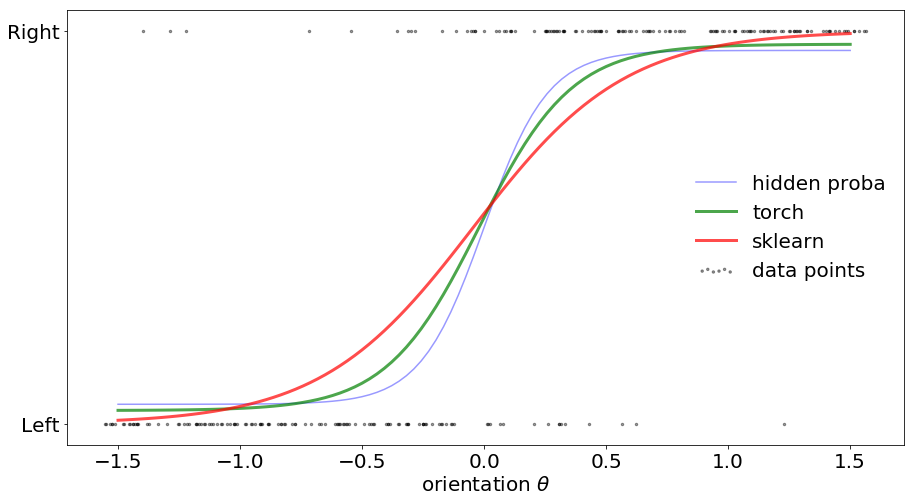

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(theta, y, s=6, alpha=0.4, color="k", label="data points")
# ax.scatter(theta, p, s=6, alpha=.4, color = 'b', label='hidden proba')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values_p = psychometric_function(x_values, p0, theta0, wt)
ax.plot(x_values, y_values_p, alpha=0.4, color="b", label="hidden proba")
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
ax.plot(x_values, y_values, "g", alpha=0.7, lw=3, label="torch")
y_values_sk = logistic_model_sk.predict_proba(x_values)[:, 1]
ax.plot(x_values, y_values_sk, "r", alpha=0.7, lw=3, label="sklearn")
ax.set_xlabel(r"orientation $\theta$", fontsize=20)
ax.set_yticks([0.0, 1.0])
ax.set_yticklabels(["Left", "Right"], fontsize=20)
plt.legend(fontsize=20, frameon=False, scatterpoints=6)
;

The losses which were computed above are those obtained during training. Relying on this value may be a dangerous strategy as the model may be overfitting the data. We should therefore measure how the model would generalize with novel data.

While it hard to do with real (experimental) data which are often scarse, here we synthesized the data and we can thus compute a testing loss by drawing again a set of new data and computing the loss on that data:

In [18]:
theta, p, y = get_data(N=N_test, seed=seed + N_test)

In [19]:
def loss_true(theta, p, y):
    labels = torch.Tensor(y[:, None])
    P = torch.Tensor(p[:, None])
    return criterion(P, labels).item() / len(theta)


print(f"Testing true loss = {loss_true(theta, p, y):.3f}")

Testing true loss = 0.283


In [20]:
logistic_model, loss = fit_data(theta, y, verbose=False)
print(f"Training loss = {loss:.3f}")

Training loss = 0.283


In [21]:
def loss_torch(logistic_model, theta, p, y):
    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])
    P = torch.Tensor(p[:, None])

    outputs = logistic_model(Theta)
    return criterion(outputs, labels).item() / len(theta)


print(f"Testing loss = {loss_torch(logistic_model, theta, p, y):.3f}")

Testing loss = 0.283


In [22]:
logistic_model_sk, loss_sk = fit_data_sklearn(theta, y, verbose=False)
print(f"Training sklearn loss = {loss_sk:.3f}")

Training sklearn loss = 0.308


In [23]:
def loss_sklearn(logistic_model, theta, p, y):
    outputs = logistic_model.predict_proba(theta[:, None])[:, 1]
    outputs_, labels = torch.Tensor(outputs[:, None]), torch.Tensor(y[:, None])
    return criterion(outputs_, labels).item() / len(theta)


print(f"Testing sklearn loss = {loss_sklearn(logistic_model_sk, theta, p, y):.3f}")

Testing sklearn loss = 0.308



## quantitative comparison of methods : varrying methods' parameters

Let's study the influence of each method's meta-parameter, such as the number of iterations:

### influence of learning rate


In [24]:
learning_rates = learning_rate * np.logspace(-1, 1, N_scan, base=10)
learning_rates_, losses, loss_Ps = [], [], []
for learning_rate_ in learning_rates:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed + i_CV)

        logistic_model, loss = fit_data(
            theta, y, learning_rate=learning_rate_, verbose=False
        )

        if N_test > 0:
            theta, p, y = get_data(N=N_test, seed=seed + i_CV + N_test)
            loss = loss_torch(logistic_model, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV == 0:
            print(
                f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}"
            )
        learning_rates_.append(learning_rate_)
        loss_Ps.append(loss_P / loss_P)
        losses.append(loss / loss_P)

learning_rate: 0.00500, Loss: 0.28664, loss_P: 0.28275
learning_rate: 0.00889, Loss: 0.28664, loss_P: 0.28275
learning_rate: 0.01581, Loss: 0.28664, loss_P: 0.28275
learning_rate: 0.02812, Loss: 0.28664, loss_P: 0.28275
learning_rate: 0.05000, Loss: 0.28664, loss_P: 0.28275
learning_rate: 0.08891, Loss: 0.28664, loss_P: 0.28275
learning_rate: 0.15811, Loss: 0.28664, loss_P: 0.28275
learning_rate: 0.28117, Loss: 0.28664, loss_P: 0.28275
learning_rate: 0.50000, Loss: 0.28664, loss_P: 0.28275


In [25]:
opts = dict(marker=".", lw=0, alpha=3 / N_cv, ms=20)

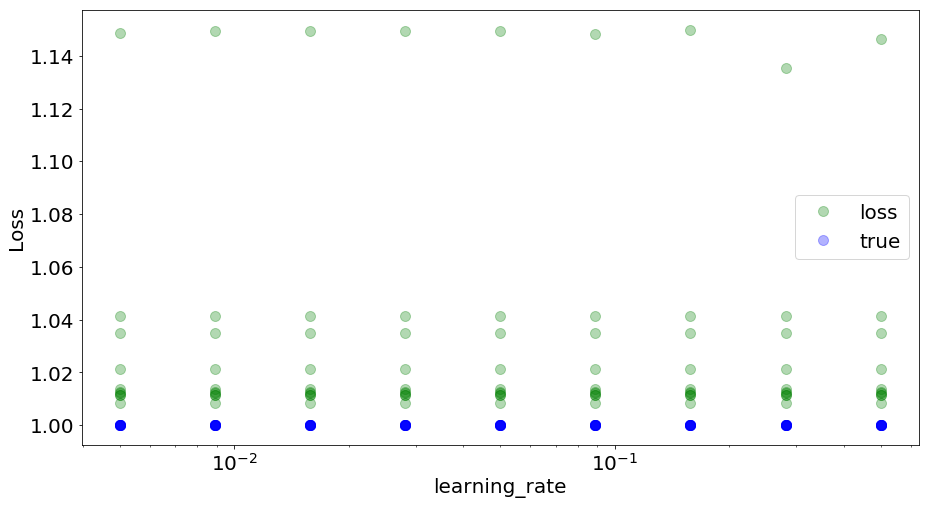

In [26]:
# influence du learning rate sur loss

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(learning_rates_, losses, **opts, color="green", label="loss")
ax.plot(learning_rates_, loss_Ps, **opts, color="blue", label="true")

# ax.set_xlim(np.min(learning_rates_), np.max(learning_rates_))

ax.set_xlabel("learning_rate")
ax.set_ylabel("Loss")
ax.set_xscale("log")
ax.legend(loc="best");

### influence du nombre d'epochs

In [27]:
num_epochss = num_epochs * np.logspace(-2, 0, N_scan, base=10)
num_epochss_, losses, loss_Ps, loss_SKLs = [], [], [], []
for num_epochs_ in num_epochss:
    for i_CV in range(N_cv):

        theta, p, y = get_data(seed=seed + i_CV)
        logistic_model, loss = fit_data(
            theta, y, num_epochs=int(num_epochs_), verbose=False
        )
        logistic_model_sk, loss_SKL = fit_data_sklearn(
            theta, y, num_epochs=int(num_epochs_), verbose=False
        )

        if N_test > 0:
            theta, p, y = get_data(N=N_test, seed=seed + i_CV + N_test)
            loss = loss_torch(logistic_model, theta, p, y)
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV == 0:
            print(
                f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}"
            )
        num_epochss_.append(num_epochs_)
        loss_SKLs.append(loss_SKL / loss_P)
        loss_Ps.append(loss_P / loss_P)
        losses.append(loss / loss_P)

/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


num_epochs: 5, Loss: 0.28515, loss_P: 0.28275, loss_SKL: 0.30951


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

num_epochs: 9, Loss: 0.28376, loss_P: 0.28275, loss_SKL: 0.30951
num_epochs: 16, Loss: 0.28727, loss_P: 0.28275, loss_SKL: 0.30951
num_epochs: 28, Loss: 0.28825, loss_P: 0.28275, loss_SKL: 0.30951
num_epochs: 51, Loss: 0.28614, loss_P: 0.28275, loss_SKL: 0.30951
num_epochs: 91, Loss: 0.28664, loss_P: 0.28275, loss_SKL: 0.30951
num_epochs: 162, Loss: 0.28664, loss_P: 0.28275, loss_SKL: 0.30951
num_epochs: 288, Loss: 0.28664, loss_P: 0.28275, loss_SKL: 0.30951
num_epochs: 513, Loss: 0.28664, loss_P: 0.28275, loss_SKL: 0.30951


''

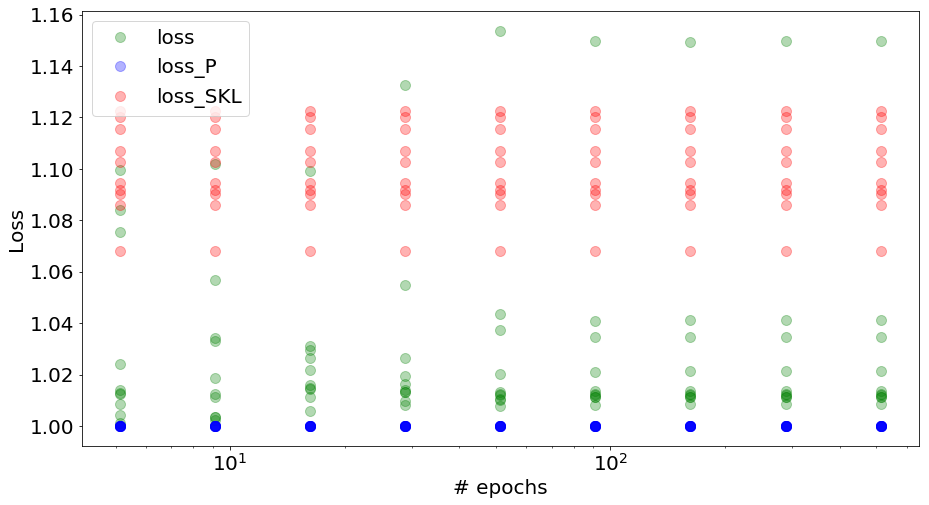

In [28]:
# influence du nbr d'epochs sur loss
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(num_epochss_, losses, **opts, color="green", label="loss")
ax.plot(num_epochss_, loss_Ps, **opts, color="blue", label="loss_P")
ax.plot(num_epochss_, loss_SKLs, **opts, color="red", label="loss_SKL")

ax.set_xlabel("# epochs")
ax.set_ylabel("Loss")
ax.set_xscale("log")
ax.legend(loc="best")
;

### influence of minibatch size

In [29]:
import time

In [30]:
batch_sizes = N * np.logspace(-3, 0, N_scan, base=2)
batch_sizes_, losses, loss_Ps = [], [], []
timings = []
for batch_size_ in batch_sizes:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed + i_CV)
        tic = time.time()
        logistic_model, loss = fit_data(
            theta, y, batch_size=int(batch_size_), verbose=False
        )
        toc = time.time()

        if N_test > 0:
            theta, p, y = get_data(N=N_test, seed=seed + i_CV + N_test)
            loss = loss_torch(logistic_model, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV == 0:
            print(
                f"batch_size: {int(batch_size_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}, CPU time: {toc-tic:.1f}"
            )
        batch_sizes_.append(batch_size_)
        loss_Ps.append(loss_P / loss_P)
        losses.append(loss / loss_P)
        timings.append(toc - tic)

batch_size: 32, Loss: 0.28709, loss_P: 0.28275, loss_SKL: 0.34166, CPU time: 16.4
batch_size: 41, Loss: 0.28626, loss_P: 0.28275, loss_SKL: 0.34166, CPU time: 14.3
batch_size: 53, Loss: 0.28635, loss_P: 0.28275, loss_SKL: 0.34166, CPU time: 11.3
batch_size: 69, Loss: 0.28663, loss_P: 0.28275, loss_SKL: 0.34166, CPU time: 8.7
batch_size: 90, Loss: 0.28757, loss_P: 0.28275, loss_SKL: 0.34166, CPU time: 11.8
batch_size: 117, Loss: 0.28666, loss_P: 0.28275, loss_SKL: 0.34166, CPU time: 8.0
batch_size: 152, Loss: 0.28626, loss_P: 0.28275, loss_SKL: 0.34166, CPU time: 6.7
batch_size: 197, Loss: 0.28655, loss_P: 0.28275, loss_SKL: 0.34166, CPU time: 8.0
batch_size: 256, Loss: 0.28664, loss_P: 0.28275, loss_SKL: 0.34166, CPU time: 5.3


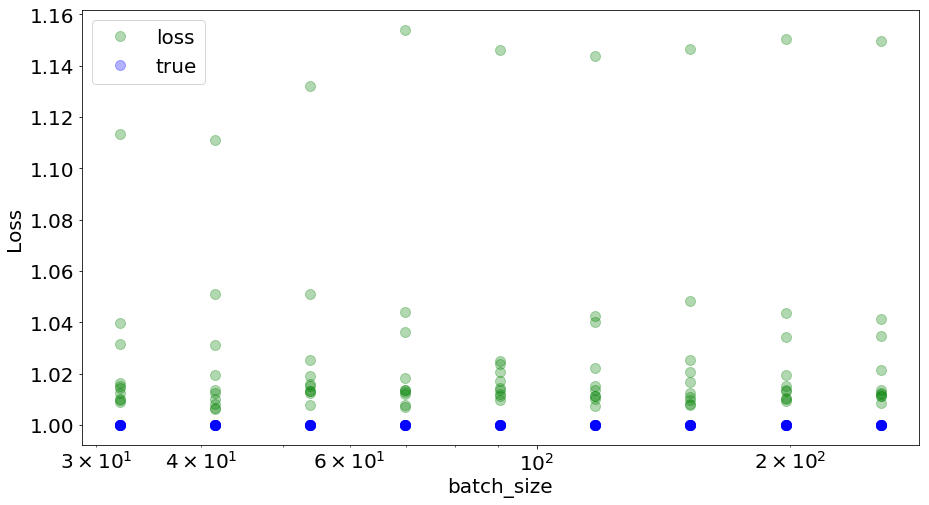

In [31]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(batch_sizes_, losses, **opts, color="green", label="loss")
ax.plot(batch_sizes_, loss_Ps, **opts, color="blue", label="true")

ax.set_xlabel("batch_size")
ax.set_ylabel("Loss ")
ax.set_xscale("log")
ax.legend(loc="best");

No handles with labels found to put in legend.


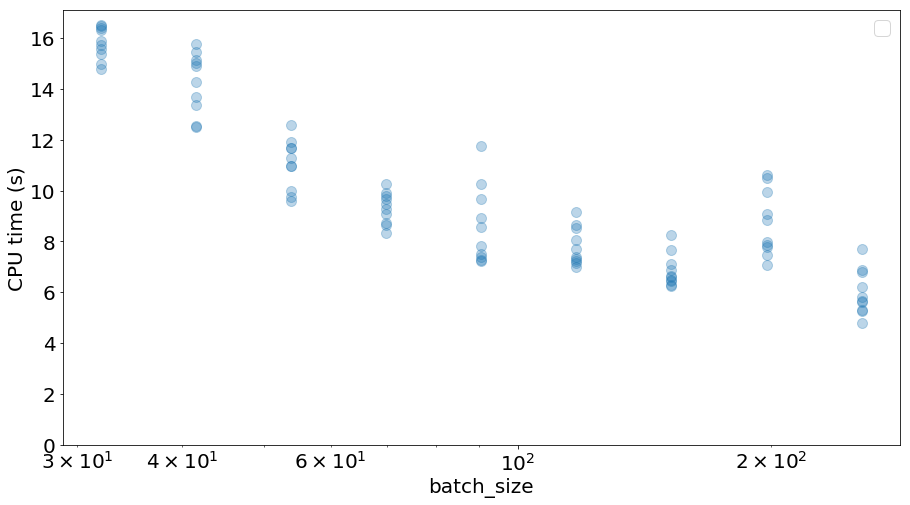

In [32]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(batch_sizes_, timings, **opts)
ax.set_xlabel("batch_size")
ax.set_ylabel("CPU time (s)")
ax.set_ylim(0)
ax.set_xscale("log")
ax.legend(loc="best");

### influence of `beta1`

In [33]:
beta1s = 1.0 - np.logspace(-3, -2, N_scan, base=10, endpoint=True)
beta1s_, losses, loss_Ps = [], [], []
for beta1_ in beta1s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed + i_CV)

        logistic_model, loss = fit_data(theta, y, betas=(beta1_, beta2), verbose=False)

        if N_test > 0:
            theta, p, y = get_data(N=N_test, seed=seed + i_CV + N_test)
            loss = loss_torch(logistic_model, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV == 0:
            print(f"beta1: {beta1_:.5f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}")
        beta1s_.append(beta1_)
        loss_Ps.append(loss_P / loss_P)
        losses.append(loss / loss_P)

beta1: 0.99900, Loss: 0.28800, loss_P: 0.28275
beta1: 0.99867, Loss: 0.28974, loss_P: 0.28275
beta1: 0.99822, Loss: 0.28953, loss_P: 0.28275
beta1: 0.99763, Loss: 0.28934, loss_P: 0.28275
beta1: 0.99684, Loss: 0.28778, loss_P: 0.28275
beta1: 0.99578, Loss: 0.28648, loss_P: 0.28275
beta1: 0.99438, Loss: 0.28536, loss_P: 0.28275
beta1: 0.99250, Loss: 0.28739, loss_P: 0.28275
beta1: 0.99000, Loss: 0.28650, loss_P: 0.28275


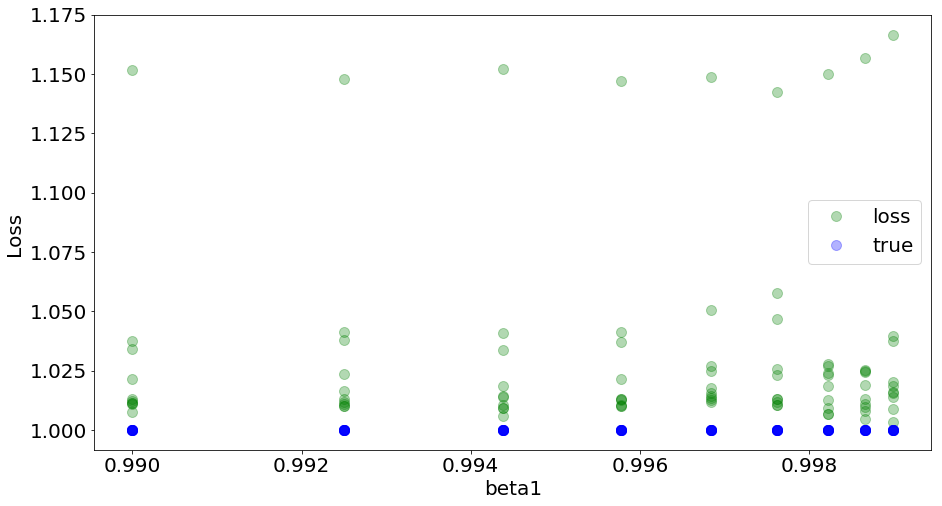

In [34]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(beta1s_, losses, **opts, color="green", label="loss")
ax.plot(beta1s_, loss_Ps, **opts, color="blue", label="true")

ax.set_xlabel("beta1")
ax.set_ylabel("Loss ")
ax.legend(loc="best");

### influence of `beta2`

In [35]:
beta2s = 1.0 - np.logspace(-7, -2, N_scan, base=10, endpoint=True)
beta2s_, losses, loss_Ps = [], [], []
for beta2_ in beta2s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed + i_CV)

        logistic_model, loss = fit_data(theta, y, betas=(beta1, beta2_), verbose=False)

        if N_test > 0:
            theta, p, y = get_data(N=N_test, seed=seed + i_CV + N_test)
            loss = loss_torch(logistic_model, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV == 0:
            print(f"beta2: {beta2_:.6f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}")
        beta2s_.append(beta2_)
        loss_Ps.append(loss_P / loss_P)
        losses.append(loss / loss_P)

beta2: 1.000000, Loss: 0.28664, loss_P: 0.28275
beta2: 1.000000, Loss: 0.28664, loss_P: 0.28275
beta2: 0.999998, Loss: 0.28664, loss_P: 0.28275
beta2: 0.999993, Loss: 0.28664, loss_P: 0.28275
beta2: 0.999968, Loss: 0.28664, loss_P: 0.28275
beta2: 0.999867, Loss: 0.28664, loss_P: 0.28275
beta2: 0.999438, Loss: 0.28664, loss_P: 0.28275
beta2: 0.997629, Loss: 0.28664, loss_P: 0.28275
beta2: 0.990000, Loss: 0.28666, loss_P: 0.28275


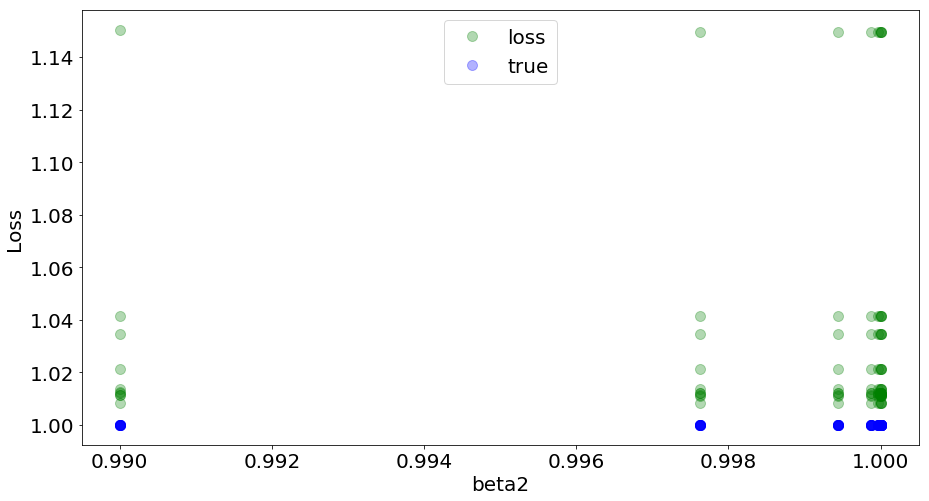

In [36]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(beta2s_, losses, **opts, color="green", label="loss")
ax.plot(beta2s_, loss_Ps, **opts, color="blue", label="true")

ax.set_xlabel("beta2")
ax.set_ylabel("Loss ")
ax.legend(loc="best");

### influence of `C`

In [37]:
Cs = C * np.logspace(-2, 2, N_scan, base=4)
Cs_, loss_Ps, loss_SKLs = [], [], []
for C_ in Cs:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed + i_CV)

        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, C=C_, verbose=False)

        if N_test > 0:
            theta, p, y = get_data(N=N_test, seed=seed + i_CV + N_test)
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV == 0:
            print(f"C: {C_:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}")

        Cs_.append(C_)
        loss_SKLs.append(loss_SKL / loss_P)
        loss_Ps.append(loss_P / loss_P)

C: 0.18750, loss_P: 0.28275, loss_SKL: 0.32859
C: 0.37500, loss_P: 0.28275, loss_SKL: 0.31652
C: 0.75000, loss_P: 0.28275, loss_SKL: 0.31143
C: 1.50000, loss_P: 0.28275, loss_SKL: 0.30980
C: 3.00000, loss_P: 0.28275, loss_SKL: 0.30951
C: 6.00000, loss_P: 0.28275, loss_SKL: 0.30957
C: 12.00000, loss_P: 0.28275, loss_SKL: 0.30967
C: 24.00000, loss_P: 0.28275, loss_SKL: 0.30974
C: 48.00000, loss_P: 0.28275, loss_SKL: 0.30978


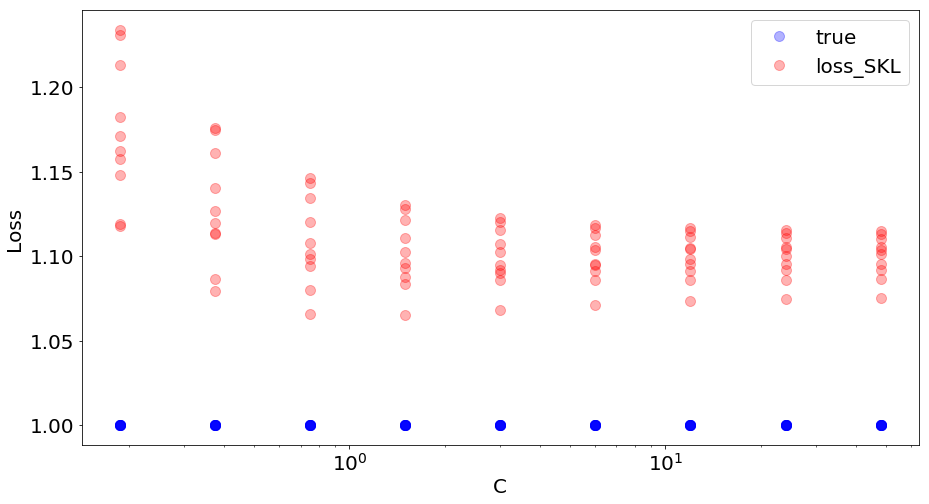

In [38]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(Cs_, loss_Ps, **opts, color="blue", label="true")
ax.plot(Cs_, loss_SKLs, **opts, color="red", label="loss_SKL")

ax.set_xlabel("C")
ax.set_ylabel("Loss ")
ax.set_xscale("log")
ax.legend(loc="best");

### influence of `tol`

In [39]:
tols = tol * np.logspace(-2, 2, N_scan, base=10)
tols_, loss_Ps, loss_SKLs = [], [], []
for tol_ in tols:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed + i_CV)

        logistic_model_sk, loss_SKL = fit_data_sklearn(
            theta, y, tol=tol_, verbose=False
        )

        if N_test > 0:
            theta, p, y = get_data(N=N_test, seed=seed + i_CV + N_test)
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV == 0:
            print(f"tol: {tol_:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}")
        tols_.append(tol_)
        loss_SKLs.append(loss_SKL / loss_P)
        loss_Ps.append(loss_P / loss_P)

tol: 0.00000, loss_P: 0.28275, loss_SKL: 0.30951
tol: 0.00000, loss_P: 0.28275, loss_SKL: 0.30951
tol: 0.00000, loss_P: 0.28275, loss_SKL: 0.30951
tol: 0.00000, loss_P: 0.28275, loss_SKL: 0.30951
tol: 0.00001, loss_P: 0.28275, loss_SKL: 0.30951
tol: 0.00003, loss_P: 0.28275, loss_SKL: 0.30951
tol: 0.00010, loss_P: 0.28275, loss_SKL: 0.30951
tol: 0.00032, loss_P: 0.28275, loss_SKL: 0.30951
tol: 0.00100, loss_P: 0.28275, loss_SKL: 0.30951


''

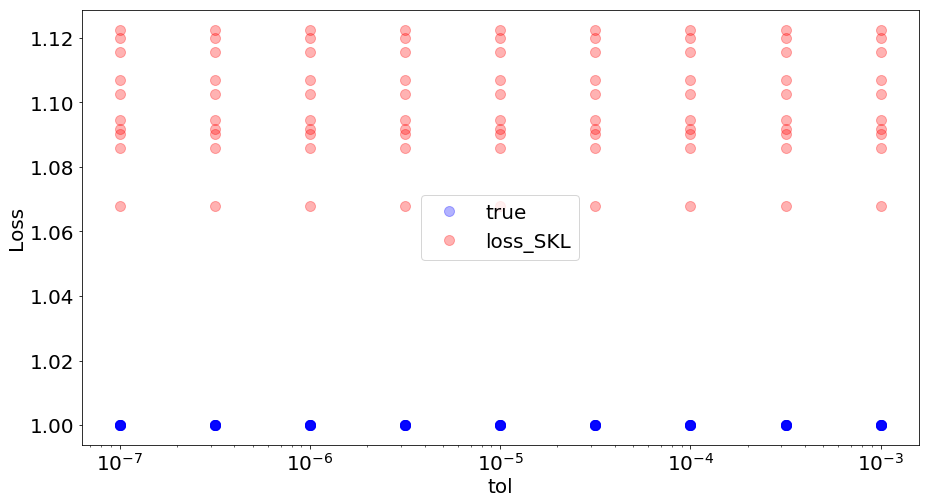

In [40]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(tols_, loss_Ps, **opts, color="blue", label="true")
ax.plot(tols_, loss_SKLs, **opts, color="red", label="loss_SKL")

ax.set_xlabel("tol")
ax.set_ylabel("Loss")
ax.set_xscale("log")
ax.legend(loc="best")
;


## quantitative comparison of methods : varrying experimental parameters


### influence of number of trials

In [41]:
Ns = np.logspace(1.5, 3, N_scan, base=10, endpoint=True)

Ns_, losses, loss_Ps, loss_SKLs = [], [], [], []

for N_ in Ns:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed + i_CV)

        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)

        if N_test > 0:
            theta, p, y = get_data(N=N_test, seed=seed + i_CV + N_test)
            loss = loss_torch(logistic_model, theta, p, y)
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV == 0:
            print(
                f"N: {int(N_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}"
            )
        loss_SKLs.append(loss_SKL / loss_P)
        Ns_.append(N_)
        loss_Ps.append(loss_P / loss_P)
        losses.append(loss / loss_P)

N: 31, Loss: 0.90497, loss_P: 0.28275, loss_SKL: 0.32684
N: 48, Loss: 0.30241, loss_P: 0.28275, loss_SKL: 0.34102
N: 74, Loss: 0.28488, loss_P: 0.28275, loss_SKL: 0.31015
N: 115, Loss: 0.28596, loss_P: 0.28275, loss_SKL: 0.31175
N: 177, Loss: 0.28650, loss_P: 0.28275, loss_SKL: 0.30929
N: 273, Loss: 0.28836, loss_P: 0.28275, loss_SKL: 0.31848
N: 421, Loss: 0.28693, loss_P: 0.28275, loss_SKL: 0.31302
N: 649, Loss: 0.28348, loss_P: 0.28275, loss_SKL: 0.30851
N: 1000, Loss: 0.28442, loss_P: 0.28275, loss_SKL: 0.30947


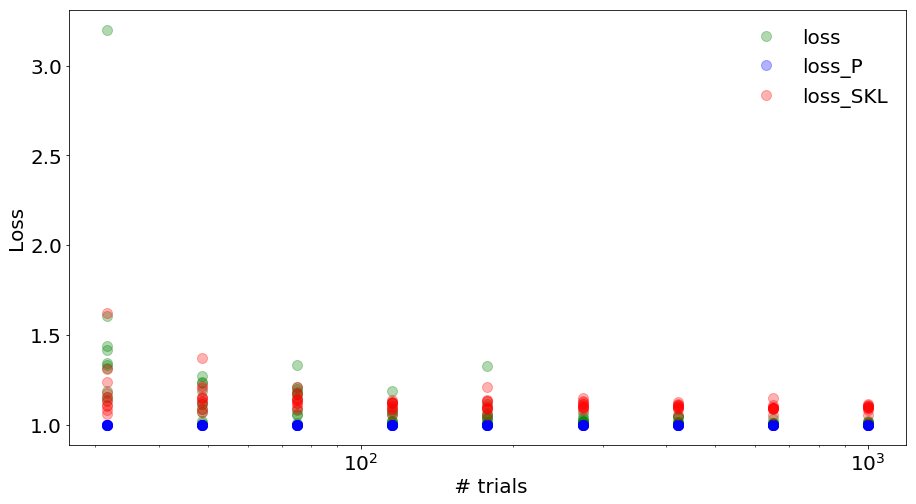

In [42]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(Ns_, losses, **opts, color="green", label="loss")
ax.plot(Ns_, loss_Ps, **opts, color="blue", label="loss_P")
ax.plot(Ns_, loss_SKLs, **opts, color="red", label="loss_SKL")

ax.set_xlabel(" # trials")
ax.set_ylabel("Loss")
ax.set_xscale("log")
plt.legend(fontsize=20, frameon=False, scatterpoints=6);

### influence of theta_std

The convergence of the fitting procedure may also depend on the parametrers of the data which were set to:

In [43]:
print(
    f"p0 = {p0:.3f}, theta0 = {theta0:.3f}, wt = {wt:.3f}, theta_std = {theta_std:.3f}"
)

p0 = 0.100, theta0 = 0.000, wt = 0.131, theta_std = 1.571


In [44]:
theta_stds = theta_std * np.logspace(-1, 1, N_scan, base=2, endpoint=True)

theta_stds_, losses, loss_Ps, loss_SKLs = [], [], [], []

for theta_std_ in theta_stds:
    for i_CV in range(N_cv):
        theta, p, y = get_data(theta_std=theta_std_, seed=seed + i_CV)

        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)

        if N_test > 0:
            theta, p, y = get_data(
                theta_std=theta_std_, N=N_test, seed=seed + i_CV + N_test
            )
            loss = loss_torch(logistic_model, theta, p, y)
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV == 0:
            print(
                f"theta_std: {theta_std_:.3f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}"
            )
        loss_SKLs.append(loss_SKL / loss_P)
        theta_stds_.append(theta_std_)
        loss_Ps.append(loss_P / loss_P)
        losses.append(loss / loss_P)

theta_std: 0.785, Loss: 0.40081, loss_P: 0.39282, loss_SKL: 0.40070
theta_std: 0.934, Loss: 0.36612, loss_P: 0.35711, loss_SKL: 0.37091
theta_std: 1.111, Loss: 0.32600, loss_P: 0.32012, loss_SKL: 0.33870
theta_std: 1.321, Loss: 0.30523, loss_P: 0.30197, loss_SKL: 0.32270
theta_std: 1.571, Loss: 0.28664, loss_P: 0.28275, loss_SKL: 0.30951
theta_std: 1.868, Loss: 0.27285, loss_P: 0.26592, loss_SKL: 0.29911
theta_std: 2.221, Loss: 0.26549, loss_P: 0.25724, loss_SKL: 0.29510
theta_std: 2.642, Loss: 0.25410, loss_P: 0.24873, loss_SKL: 0.29217
theta_std: 3.142, Loss: 0.24929, loss_P: 0.24255, loss_SKL: 0.28945


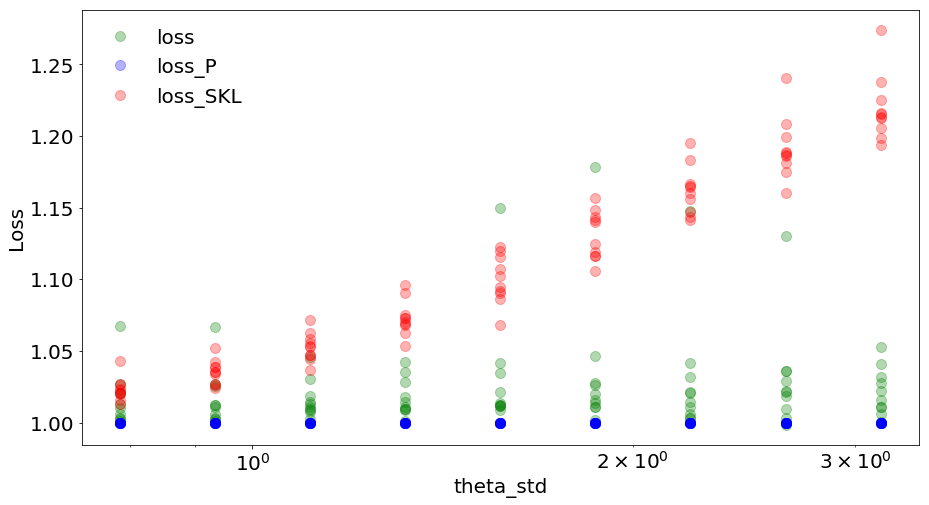

In [45]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(theta_stds_, losses, **opts, color="green", label="loss")
ax.plot(theta_stds_, loss_Ps, **opts, color="blue", label="loss_P")
ax.plot(theta_stds_, loss_SKLs, **opts, color="red", label="loss_SKL")

ax.set_xlabel("theta_std")
ax.set_ylabel("Loss")
ax.set_xscale("log")
plt.legend(fontsize=20, frameon=False, scatterpoints=6);

### influence of `p0`



In [46]:
p0s = np.logspace(-3, -0.7, N_scan, base=10, endpoint=True)

p0s_, losses, loss_Ps, loss_SKLs = [], [], [], []

for p0_ in p0s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(p0=p0_, seed=seed + i_CV)

        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)

        if N_test > 0:
            theta, p, y = get_data(p0=p0_, N=N_test, seed=seed + i_CV)
            loss = loss_torch(logistic_model, theta, p, y)
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV == 0:
            print(
                f"p0: {p0_:.3f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}"
            )
        loss_SKLs.append(loss_SKL / loss_P)
        p0s_.append(p0_)
        loss_Ps.append(loss_P / loss_P)
        losses.append(loss / loss_P)

p0: 0.001, Loss: 0.15198, loss_P: 0.14552, loss_SKL: 0.15928
p0: 0.002, Loss: 0.15254, loss_P: 0.14623, loss_SKL: 0.15977
p0: 0.004, Loss: 0.15556, loss_P: 0.15068, loss_SKL: 0.16240
p0: 0.007, Loss: 0.17212, loss_P: 0.16712, loss_SKL: 0.17739
p0: 0.014, Loss: 0.17688, loss_P: 0.17316, loss_SKL: 0.18745
p0: 0.027, Loss: 0.19255, loss_P: 0.19044, loss_SKL: 0.20387
p0: 0.053, Loss: 0.24270, loss_P: 0.23688, loss_SKL: 0.25324
p0: 0.103, Loss: 0.30432, loss_P: 0.30186, loss_SKL: 0.32587
p0: 0.200, Loss: 0.41153, loss_P: 0.40658, loss_SKL: 0.43834


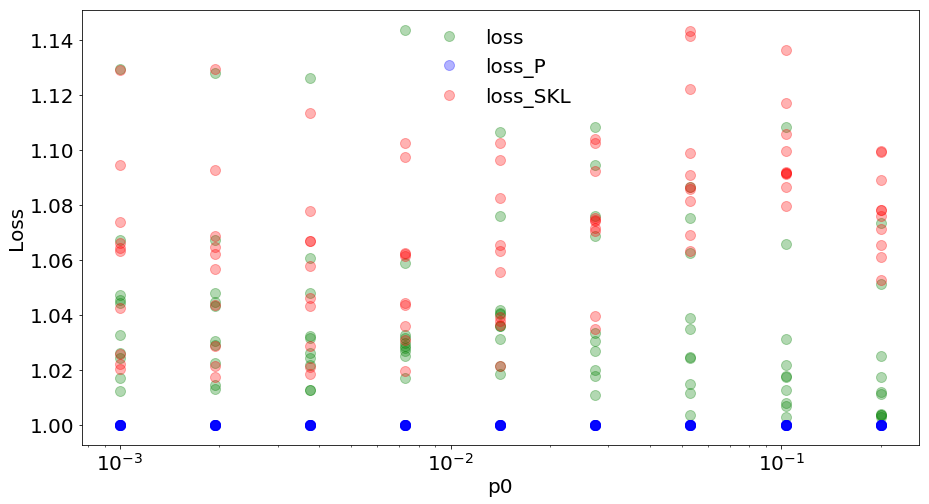

In [47]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(p0s_, losses, **opts, color="green", label="loss")
ax.plot(p0s_, loss_Ps, **opts, color="blue", label="loss_P")
ax.plot(p0s_, loss_SKLs, **opts, color="red", label="loss_SKL")

ax.set_xlabel("p0")
ax.set_ylabel("Loss")
ax.set_xscale("log")
plt.legend(fontsize=20, frameon=False, scatterpoints=6);



## comparing the predicted values


In [48]:
print(
    f"p0 = {p0:.3f}, theta0 = {theta0:.3f}, wt = {wt:.3f}, theta_std = {theta_std:.3f}"
)

p0 = 0.100, theta0 = 0.000, wt = 0.131, theta_std = 1.571




### changing `p0`


In [49]:
N_scan = 20
p0s = np.logspace(-3, -0.7, N_scan, base=10, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_sks, wt_tos, wt_sks = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

for p0_ in p0s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(p0=p0_, seed=seed + i_CV)

        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)

        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_sk, wt_sk = get_params_sk(logistic_model_sk, verbose=False)

        p0s_.append(p0_)
        theta0s_.append(theta0)
        wts_.append(wt)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_sks.append(theta0_sk)
        wt_tos.append(wt_to)
        wt_sks.append(wt_sk)

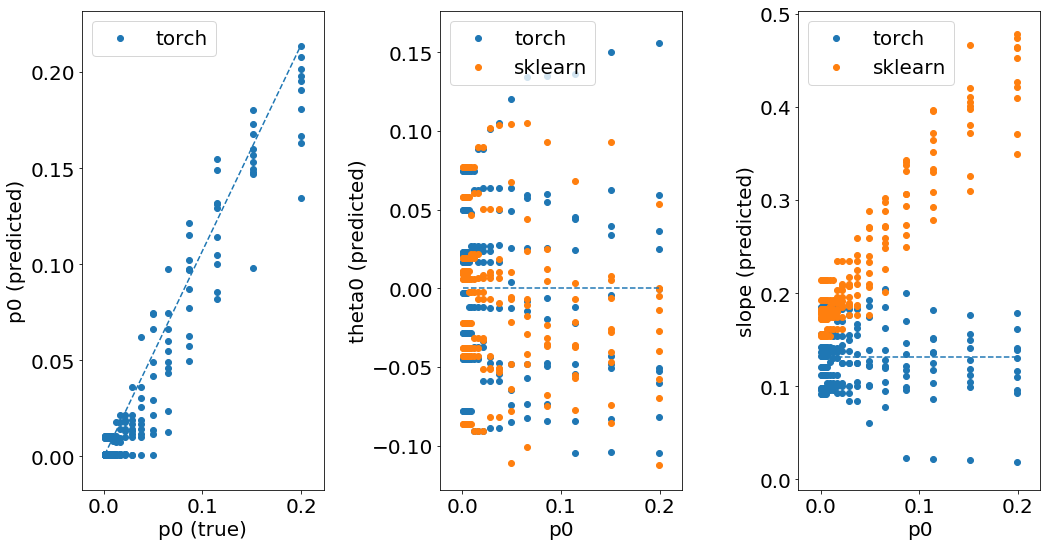

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(p0s_, p0_tos, label="torch")
axs[0].plot([min(p0s_), max(p0s_)], [min(p0_tos), max(p0_tos)], "--")
axs[0].set(xlabel="p0 (true)", ylabel="p0 (predicted)")
axs[0].legend(loc="upper left")

axs[1].scatter(p0s_, theta0_tos, label="torch")
axs[1].scatter(p0s_, theta0_sks, label="sklearn")
axs[1].plot([min(p0s_), max(p0s_)], [theta0, theta0], "--")
axs[1].set(xlabel="p0", ylabel="theta0 (predicted)")
axs[1].legend(loc="upper left")

axs[2].scatter(p0s_, wt_tos, label="torch")
axs[2].scatter(p0s_, wt_sks, label="sklearn")
axs[2].plot([min(p0s_), max(p0s_)], [wt, wt], "--")
axs[2].set(xlabel="p0", ylabel="slope (predicted)")
axs[2].legend(loc="upper left")
plt.tight_layout();



### changing `theta0`


In [51]:
N_scan = 20
theta0s = theta_std * np.linspace(-1, 1, N_scan, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_sks, wt_tos, wt_sks = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

for theta0_ in theta0s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(theta0=theta0_, seed=seed + i_CV)

        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)

        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_sk, wt_sk = get_params_sk(logistic_model_sk, verbose=False)

        p0s_.append(p0)
        theta0s_.append(theta0_)
        wts_.append(wt)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_sks.append(theta0_sk)
        wt_tos.append(wt_to)
        wt_sks.append(wt_sk)

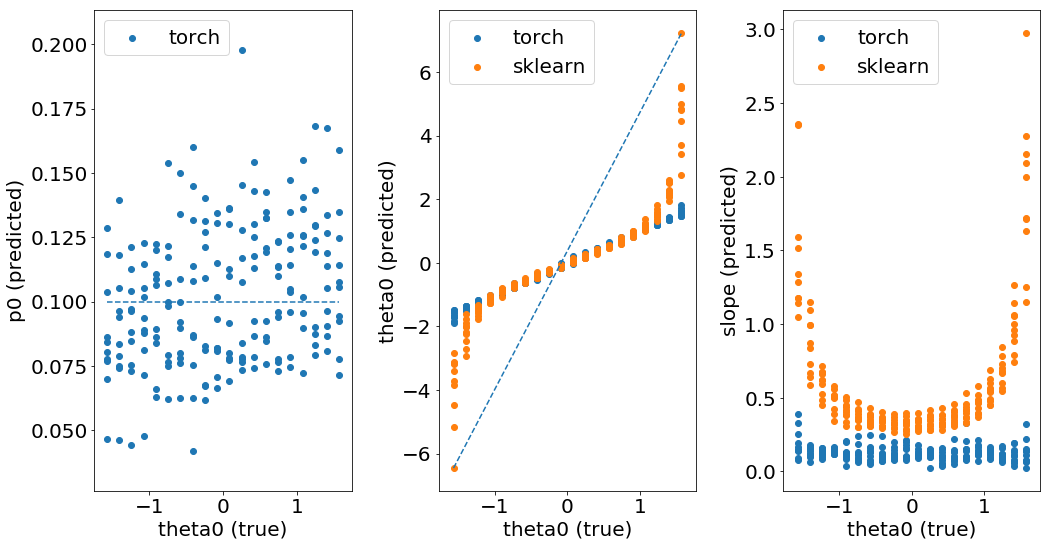

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(theta0s_, p0_tos, label="torch")
axs[0].plot([min(theta0s_), max(theta0s_)], [p0, p0], "--")
axs[0].set(xlabel="theta0 (true)", ylabel="p0 (predicted)")
axs[0].legend(loc="upper left")

axs[1].scatter(theta0s_, theta0_tos, label="torch")
axs[1].scatter(theta0s_, theta0_sks, label="sklearn")
axs[1].plot([min(theta0s_), max(theta0s_)], [min(theta0_sks), max(theta0_sks)], "--")
axs[1].set(xlabel="theta0 (true)", ylabel="theta0 (predicted)")
axs[1].legend(loc="upper left")

axs[2].scatter(theta0s_, wt_tos, label="torch")
axs[2].scatter(theta0s_, wt_sks, label="sklearn")
axs[2].plot([min(p0s_), max(p0s_)], [wt, wt], "--")
axs[2].set(xlabel="theta0 (true)", ylabel="slope (predicted)")
axs[2].legend(loc="upper left")
plt.tight_layout();



### changing `wt`


In [53]:
N_scan = 20
wts = wt * np.logspace(-1, 1, N_scan, base=4, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_sks, wt_tos, wt_sks = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

for wt_ in wts:
    for i_CV in range(N_cv):
        theta, p, y = get_data(wt=wt_, seed=seed + i_CV)

        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)

        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_sk, wt_sk = get_params_sk(logistic_model_sk, verbose=False)

        p0s_.append(p0)
        theta0s_.append(theta0)
        wts_.append(wt_)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_sks.append(theta0_sk)
        wt_tos.append(wt_to)
        wt_sks.append(wt_sk)

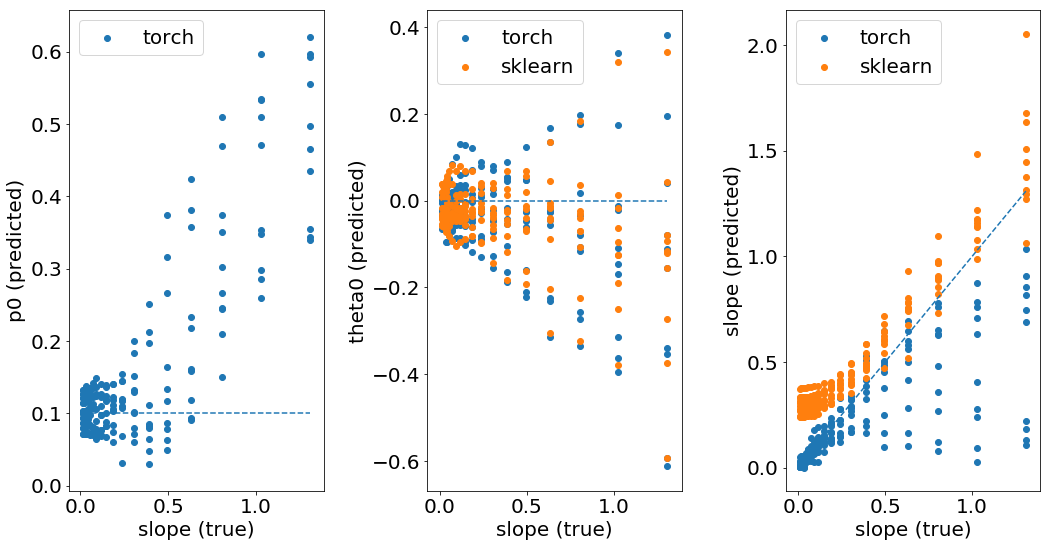

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(wts_, p0_tos, label="torch")
axs[0].plot([min(wts_), max(wts_)], [p0, p0], "--")

axs[0].set(xlabel="slope (true)", ylabel="p0 (predicted)")
axs[0].legend(loc="upper left")

axs[1].scatter(wts_, theta0_tos, label="torch")
axs[1].scatter(wts_, theta0_sks, label="sklearn")
axs[1].plot([min(wts_), max(wts_)], [theta0, theta0], "--")
axs[1].set(xlabel="slope (true)", ylabel="theta0 (predicted)")
axs[1].legend(loc="upper left")

axs[2].scatter(wts_, wt_tos, label="torch")
axs[2].scatter(wts_, wt_sks, label="sklearn")
axs[2].plot([min(wts_), max(wts_)], [min(wts_), max(wts_)], "--")
axs[2].set(xlabel="slope (true)", ylabel="slope (predicted)")
axs[2].legend(loc="upper left")
plt.tight_layout();